In [1]:
import os
# import scvi
import rpy2
# import scib
import json
# import scgen
# import torch
import anndata
import logging
import warnings
# import scanorama
import anndata2ri
import matplotlib
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from scipy.sparse import csr_matrix
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
executing                   1.2.0
h5py                        3.8.0
ipykernel                   6.22.0
ipython_genutils            0.2.0
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
llvmlite                    0.39.1
markupsafe                  2.1.2
matplotlib                  3.7.1
mpl_toolkits                NA
natsort                     8.3.1
numba 

In [4]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(Seurat)
    library(tibble)
    library(magrittr) # needs to be run every time you start R and want to use %>%
})



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
adata_annot = sc.read_h5ad('../data/processed/allen_mtg/allen_mtg_annotated_anndata.h5ad')
meta = pd.read_csv('../data/raw/allen_mtg/allen_mtg_metadata.csv')
meta = meta.astype(str)
mapping = dict(zip(meta['individualID'], meta['pathology.group']))
adata_annot.obs['pathology.group'] = adata_annot.obs['individualID'].map(mapping)
#adata_annot.X = csr_matrix(adata_annot.layers['counts'].toarray())

In [6]:
adata_annot

AnnData object with n_obs × n_vars = 104349 × 17950
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y', 'race', 'ethnicity', 'yearsEducation', 'ageDeath', 'causeDeath', 'mannerDeath', 'apoe4Status', 'apoeGenotype', 'pmi', 'pH', 'brainW

## 2.4 Systematic differential analysis of gene expression

[**Hansruedi Mathys et. al.**](https://doi.org/10.1038/s41586-019-1195-2) compared gene expression levels between `AD-pathology and no-pathology individuals in a cell type manner. The differential expression analysis was assessed using two tests. 

- **First**, a cell-level analysis was performed using the Wilcoxon rank-sum test and FDR multiple-testing correction (`FDR-adjusted p-values`). 

- **Second**, a Poisson mixed model accounting for the individual of origin for nuclei and for unwanted sources of variability was performed using the R packages `lme4` and `RUV-seq`, respectively.


Next, we use the ` Wilcoxon rank-sum test` in `scapany.tl.rank_genes_group` comparing `AD-pathology` group to `no-pathology` such that the log foldchange is ;

$$ Log_{2} ({Mean\ Gene\ Expression\ in\ AD\ category\ of\ Cell\ Type\ x \over Mean\ Gene\ Expression\ in\ Normal\ category\ of\ Cell\ Type\ x})$$


##### Group Cells (Pathology / No-Pathology)

In [9]:
adata_annot.obs['disease_group'] = None
adata_annot.obs.loc[adata_annot.obs['pathology.group'] == 'no', 'disease_group'] = 'no'
adata_annot.obs.loc[adata_annot.obs['pathology.group'].isin(['early', 'late']), 'disease_group'] = 'ad'

##### Load DEGs from Cell-type Differential Expression with Wilcoxon Rank-Sum and MAST Tests

In [8]:
adata_annot.uns['log1p'] = {'base': None}

adata_sub = {}
degs_t_test = {}
for cell_type in adata_annot.obs.cell_type.unique():

    # adata_sub[cell_type] = adata_annot[adata_annot.obs.cell_type==cell_type]
    # adata_sub[cell_type].X = adata_sub[cell_type].layers['counts'].toarray()
    degs_t_test[cell_type] = pd.read_excel('../results/ad_vs_no/t_test_degs.xlsx', 
                                   sheet_name=cell_type)
    degs_t_test[cell_type] = pd.read_excel('../results/ad_vs_no/t_test_degs.xlsx', 
                                   sheet_name=cell_type)


Reported DEGs

Next, we load the reported DEGs from [**Hansruedi Mathys et. al.**](https://doi.org/10.1038/s41586-019-1195-2) for comparison in a later step

In [9]:
mathys_degs = {}
for key in adata_annot.obs.cell_type.unique():
    try:
        mathys_degs[key] = pd.read_excel(f'../data/raw/mathys_pfc_from_paper/degs/ad_vs_no/{key.lower()}_degs.xlsx')
        mathys_degs[key].rename({'Unnamed: 0': 'names'}, inplace=True)
        mathys_degs[key]['IndModel.absFC'] = np.abs(mathys_degs[key]['IndModel.FC'])

    except FileNotFoundError:
        continue

## **Pseduo-bulk Differential Expression Analysis with DESeq2 and EdgeR**

Although we have previously estimated the differentially expressed genes using `MAST` in Seurat, we furthure employ both, pseudobulk methods with sum aggregation such as `edgeR` and `DESeq2`, and ultimately compare the results with those from the mixed models in `MAST`.


Pseudo-bulk methods are originally designed for bulk gene expression data. It implements a wide range of statistical methodology based on the negative binomial distribution, empirical Bayes estimation, exact tests, generalized linear models (GLMs) and quasi-likelihood tests, whereas, the cell-level view models cells ndividually using generalized mixed effect models and as a result. single-cell-specific methods are found to systematically underestimate the variance of gene expression and to be prone to wrongly labelling highly expressed genes as differentially expressed.

This could in turn affect the true positive rate (TPR) and precision. This is becasue `Pseudoreplication leads to an inflated false discovery rate (FDR) as DGE methods do not account for the inherent correlation of replicates (cells from the same individual)`. |Within-sample correlation should be accounted for by aggregating cell-type-specific counts within an individual before DGE analysis.

Here, we showcase use decoupler (to create pseudobulks) and pyDESeq2 (for bulk RNA-seq differential expression analysis)

### **Generate Pseudo-bulks**


Here we perform differential expression analysis between conditions within particular cell types. `DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample.` We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results.

The current best practice to correct for this is using a pseudo-bulk approach (Squair J.W., et al 2021), which involves the following steps:

- Subsetting the cell type(s) of interest to perform DEA.

- Extracting their raw integer counts.

- Summing their counts per gene into a single profile if they pass quality control.

- Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).


We can pseudobulk using the function `decoupler.get_pseudobulk`. Here, we are interested in `summing the counts` but other modes are available, please see documentation

In [14]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(adata_annot,
                          sample_col='PatientID',
                          groups_col='cell_type',
                          layer='counts',
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdata

AnnData object with n_obs × n_vars = 70 × 16585
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

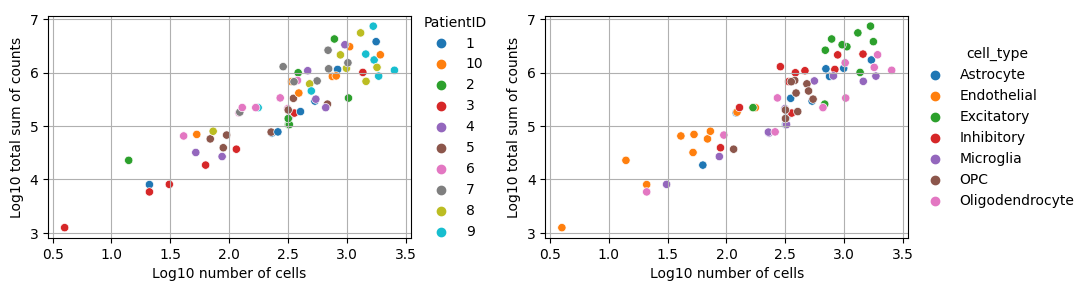

In [15]:
#from decoupler.plotting import plot_psbulk_samples

dc.plot_psbulk_samples(pdata, groupby=['PatientID', 'cell_type'], figsize=(11, 3), )

There are two criteria to filter low quality samples: its number of cells `(psbulk_n_cells)`, and its total sum of counts `(psbulk_counts)`. 

In these plots it can be seen that there are some samples of `Endothelial cells` that contain less than 10 cells, we remove them by using the arguments `min_cells` and `min_counts`. 

These thresholds are arbitrary and will change depening on the dataset, but a good rule of thumb is to have at least `10 cells with 1000 accumulated count`.

In [16]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(adata_annot,
                          sample_col='PatientID',
                          groups_col='cell_type',
                          layer='counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 69 × 16585
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

Additionally, we also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. This step is done at the cell type level, since each cell type may express different collection of genes.


To filter genes, we follow the strategy implemented in the function `filterByExpr from edgeR`. It keeps genes that have a minimum total number of reads across samples `(min_total_count)`, and that have a minimum number of counts in a number of samples `(min_count)`.


We can plot how many genes to keep by changing the `min_count` and `min_total_count` to check how many genes would be kept when changed


Astrocyte...
Endothelial...
Excitatory...
Inhibitory...
Microglia...
OPC...
Oligodendrocyte...


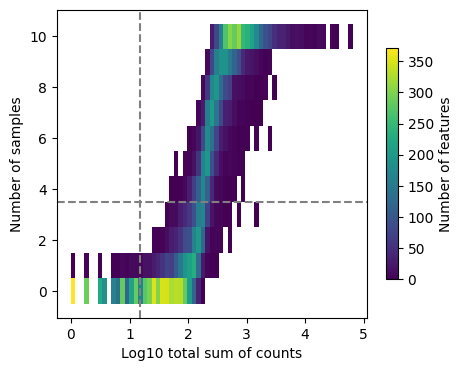

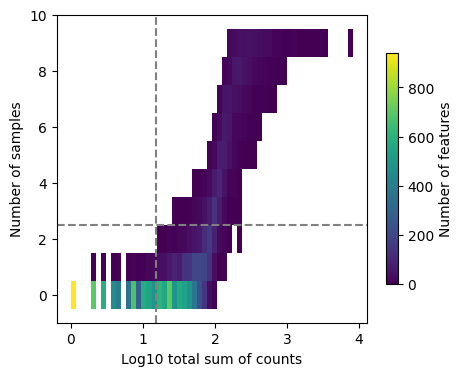

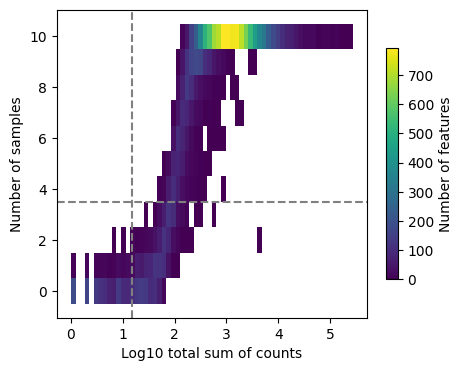

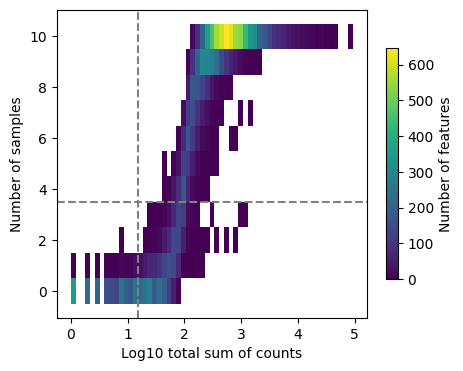

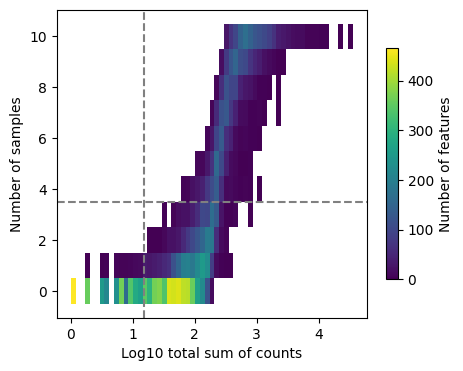

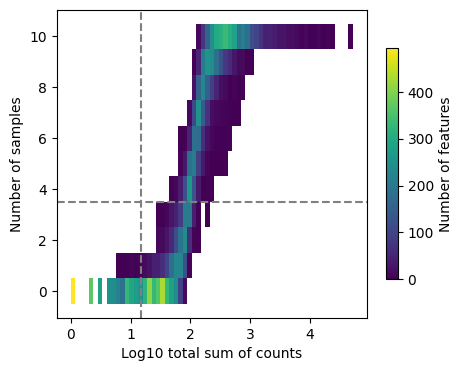

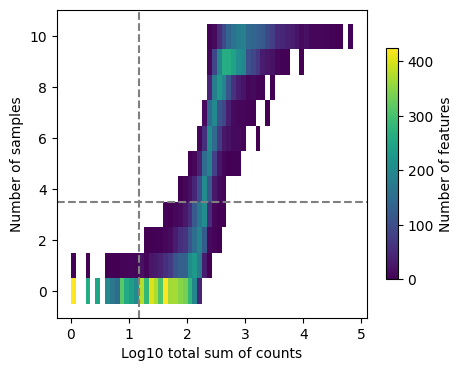

In [17]:
for cell_type in pdata.obs.cell_type.unique():
    temp = pdata[pdata.obs['cell_type'] == cell_type].copy()
    print(f'{cell_type}...')
    dc.plot_filter_by_expr(temp, group='disease_group',
                        min_count=10, min_total_count=15)


Here we can observe the frequency of genes with different total sum of counts and number of samples. With the default values we would keep a good quantity of genes while filtering potential noisy genes.

Next, we perform the actual filtering:

In [18]:
adata_sub = {}

for cell_type in pdata.obs.cell_type.unique():

    print(f'filtering genes in {cell_type}...')
    adata_sub[cell_type] = pdata[pdata.obs['cell_type'] == cell_type].copy()

    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(adata_sub[cell_type], group='disease_group', min_count=10, min_total_count=15)
    genes = dc.filter_by_prop(adata_sub[cell_type], min_prop=0.05)

    # Filter by these genes
    adata_sub[cell_type] = adata_sub[cell_type][:, genes].copy()
    print(adata_sub[cell_type])
    print('\n')

filtering genes in Astrocyte...
AnnData object with n_obs × n_vars = 10 × 6207
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Endothelial...
AnnData object with n_obs × n_vars = 9 × 7734
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Excitatory...
AnnData object with n_obs × n_vars = 10 × 10094
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Inhibitory...
AnnData object with n_obs × n_vars = 10 × 8783
    obs: 'SampleID', 'PatientID', 'BrainRegion'

In [19]:
pdata.obs

,SampleID,PatientID,BrainRegion,BraakStage,SampleBatch,cell_type,predicted_doublet,pathology.group,disease_group,psbulk_n_cells,psbulk_counts
1_Astrocyte,EC1,1,EC,0,C,Astrocyte,False,no,no,534.0,292614.0
10_Astrocyte,EC10,10,EC,6,D,Astrocyte,False,late,ad,751.0,846938.0
2_Astrocyte,EC2,2,EC,0,C,Astrocyte,False,no,no,318.0,106333.0
3_Astrocyte,EC3,3,EC,0,C,Astrocyte,False,no,no,63.0,18545.0
4_Astrocyte,EC4,4,EC,2,C,Astrocyte,False,no,no,323.0,144872.0
...,...,...,...,...,...,...,...,...,...,...,...
5_Oligodendrocyte,EC5,5,EC,2,B,Oligodendrocyte,False,early,ad,95.0,67619.0
6_Oligodendrocyte,EC6,6,EC,2,D,Oligodendrocyte,False,early,ad,271.0,335335.0
7_Oligodendrocyte,EC7,7,EC,2,D,Oligodendrocyte,False,early,ad,1019.0,1523743.0
8_Oligodendrocyte,EC8,8,EC,6,B,Oligodendrocyte,False,late,ad,1799.0,1250429.0


Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented in `decoupler.filter_by_prop`.



### **Contrast between conditions**

Now, using the robust pseudo-bulk profiles we generated, we next compute DEA. 

Here, we will use a simple design matrix where we compare the gene expression in each cell-type from diseased patients against controls. We use the python implementation of the framework `DESeq2`. We provide optionality to include more complex experimental designs by adding more factors to the design_factors argument.



In [20]:
dds = {}
stat_res = {}
results = {}

for key in adata_sub.keys():# Build DESeq2 object
    print(f'ESTIMATING CHANGES IN {key.capitalize()}....')
    dds[key] = DeseqDataSet(
        adata=adata_sub[key],
        design_factors=['disease_group'],
        tested_level = ['disease_group', 'ad'],
        refit_cooks=True,
        n_cpus=8,
        )
    # Compute LFCs
    dds[key].deseq2()

    # Extract contrast between AD vs normal
    stat_res[key] = DeseqStats(dds[key], contrast=["disease_group", 'ad', 'no'], n_cpus=8)
    
    # Compute Wald test
    stat_res[key].summary()

    # Shrink LFCs
    stat_res[key].lfc_shrink(coeff='disease_group_ad_vs_no')

    # Extract results
    results[key] = stat_res[key].results_df


ESTIMATING CHANGES IN Astrocyte....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.45 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 4.16 seconds.

Fitting LFCs...
... done in 0.41 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.16 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,13.791571,1.131402,0.657208,1.721527,0.085155,0.225769
AAAS,14.494428,-0.538177,0.409046,-1.315689,0.188278,0.377654
AAGAB,13.437780,0.388463,0.433330,0.896460,0.370007,0.582283
AAK1,60.212410,0.288889,0.248904,1.160647,0.245785,0.449550
AAMDC,20.839342,0.474299,0.429824,1.103473,0.269822,0.479537
...,...,...,...,...,...,...
ZSWIM8,36.409431,-0.738653,0.358589,-2.059886,0.039409,0.136949
ZXDC,31.521423,0.957558,0.368262,2.600207,0.009317,0.051438
ZYG11B,26.798878,-0.238384,0.217927,-1.093871,0.274011,0.483696
ZZEF1,24.067583,-0.250021,0.286234,-0.873485,0.382399,0.591048


Fitting MAP LFCs...
... done in 0.66 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,13.791571,0.502493,0.639606,1.721527,0.085155,0.225769
AAAS,14.494428,-0.332983,0.396357,-1.315689,0.188278,0.377654
AAGAB,13.437780,0.225119,0.402684,0.896460,0.370007,0.582283
AAK1,60.212410,0.232296,0.242299,1.160647,0.245785,0.449550
AAMDC,20.839342,0.274983,0.411984,1.103473,0.269822,0.479537
...,...,...,...,...,...,...
ZSWIM8,36.409431,-0.547713,0.356012,-2.059886,0.039409,0.136949
ZXDC,31.521423,0.757378,0.368062,2.600207,0.009317,0.051438
ZYG11B,26.798878,-0.144270,0.903363,-1.093871,0.274011,0.483696
ZZEF1,24.067583,-0.186661,0.277001,-0.873485,0.382399,0.591048


ESTIMATING CHANGES IN Endothelial....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.20 seconds.

Fitting dispersion trend curve...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 0.43 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.22 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,1.183020,1.830383,2.212510,0.827288,0.408074,NaN
A2M,28.197435,0.977012,0.480404,2.033728,0.041979,0.332138
A4GALT,3.368488,1.482371,1.033395,1.434467,0.151439,0.516245
AAAS,1.889470,-0.531725,0.942996,-0.563867,0.572844,NaN
AAGAB,1.894778,1.574061,1.426713,1.103278,0.269906,NaN
...,...,...,...,...,...,...
ZXDC,3.995847,1.072657,0.989142,1.084431,0.278174,0.638962
ZYG11B,5.019523,-0.017867,0.674152,-0.026503,0.978856,0.995970
ZYX,4.718576,-0.134704,0.876397,-0.153702,0.877844,0.968234
ZZEF1,3.443883,0.893623,0.985405,0.906858,0.364482,0.709360


Fitting MAP LFCs...
... done in 0.74 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,1.183020,0.108885,1.020908,0.827288,0.408074,NaN
A2M,28.197435,0.567567,0.481726,2.033728,0.041979,0.332138
A4GALT,3.368488,-0.144270,0.922095,1.434467,0.151439,0.516245
AAAS,1.889470,-0.075996,0.769868,-0.563867,0.572844,NaN
AAGAB,1.894778,0.193520,0.826720,1.103278,0.269906,NaN
...,...,...,...,...,...,...
ZXDC,3.995847,0.186865,0.702189,1.084431,0.278174,0.638962
ZYG11B,5.019523,-0.004277,0.554297,-0.026503,0.978856,0.995970
ZYX,4.718576,-0.022300,0.614432,-0.153702,0.877844,0.968234
ZZEF1,3.443883,0.152491,0.692461,0.906858,0.364482,0.709360


ESTIMATING CHANGES IN Excitatory....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 5.71 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 6.38 seconds.

Fitting LFCs...
... done in 0.50 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.26 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,44.668682,0.020055,0.279836,0.071665,0.942868,0.963053
A2ML1,20.431484,1.179092,0.417588,2.823580,0.004749,0.019797
AAAS,34.547066,-0.496257,0.297235,-1.669580,0.095003,0.184667
AACS,186.054672,-0.535067,0.252801,-2.116551,0.034298,0.086644
AADAT,19.925383,0.554362,0.311226,1.781221,0.074876,0.155579
...,...,...,...,...,...,...
ZXDC,105.832764,0.153018,0.161581,0.947007,0.343635,0.477485
ZYG11B,286.587036,-0.608789,0.130697,-4.658034,0.000003,0.000069
ZYX,102.234039,-0.911131,0.259132,-3.516085,0.000438,0.003147
ZZEF1,131.364090,0.097425,0.171297,0.568750,0.569526,0.686472


Fitting MAP LFCs...
... done in 0.94 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,44.668682,0.013565,0.253359,0.071665,0.942868,0.963053
A2ML1,20.431484,0.903650,0.427299,2.823580,0.004749,0.019797
AAAS,34.547066,-0.347830,0.288274,-1.669580,0.095003,0.184667
AACS,186.054672,-0.423984,0.247458,-2.116551,0.034298,0.086644
AADAT,19.925383,0.390588,0.302565,1.781221,0.074876,0.155579
...,...,...,...,...,...,...
ZXDC,105.832764,0.131892,0.157542,0.947007,0.343635,0.477485
ZYG11B,286.587036,-0.577516,0.130092,-4.658034,0.000003,0.000069
ZYX,102.234039,-0.796982,0.260978,-3.516085,0.000438,0.003147
ZZEF1,131.364090,0.082165,0.165917,0.568750,0.569526,0.686472


ESTIMATING CHANGES IN Inhibitory....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.74 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 5.34 seconds.

Fitting LFCs...
... done in 0.39 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.23 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,10.940746,0.206659,0.431936,0.478449,0.632331,0.774623
A2ML1,9.434161,1.435047,0.639399,2.244369,0.024809,0.092151
AAAS,15.078306,0.153943,0.478480,0.321734,0.747654,0.857332
AACS,25.804523,-0.685894,0.262622,-2.611721,0.009009,0.045359
AADAT,10.221308,0.137069,0.359987,0.380760,0.703381,0.827328
...,...,...,...,...,...,...
ZXDC,28.957560,0.236890,0.312515,0.758011,0.448444,0.628037
ZYG11B,115.081406,-0.553080,0.177552,-3.115028,0.001839,0.014792
ZYX,24.516003,-0.591976,0.312186,-1.896230,0.057930,0.163932
ZZEF1,42.280422,-0.091955,0.130885,-0.702565,0.482327,0.657028


Fitting MAP LFCs...
... done in 0.84 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,10.940746,0.082726,0.341945,0.478449,0.632331,0.774623
A2ML1,9.434161,0.640664,0.684271,2.244369,0.024809,0.092151
AAAS,15.078306,0.049691,0.369208,0.321734,0.747654,0.857332
AACS,25.804523,-0.543735,0.264080,-2.611721,0.009009,0.045359
AADAT,10.221308,0.065003,0.305999,0.380760,0.703381,0.827328
...,...,...,...,...,...,...
ZXDC,28.957560,0.133333,0.278285,0.758011,0.448444,0.628037
ZYG11B,115.081406,-0.486515,0.178691,-3.115028,0.001839,0.014792
ZYX,24.516003,-0.392895,0.305295,-1.896230,0.057930,0.163932
ZZEF1,42.280422,-0.080432,0.127505,-0.702565,0.482327,0.657028


ESTIMATING CHANGES IN Microglia....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.41 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 2.66 seconds.

Fitting LFCs...
... done in 0.23 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.12 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,77.610939,0.144943,0.636198,0.227826,0.819781,0.925459
AAK1,79.472870,-0.258564,0.277314,-0.932387,0.351137,0.630436
AAMDC,6.965267,0.865581,0.639022,1.354539,0.175565,NaN
AASDH,12.074767,-0.827493,0.309495,-2.673689,0.007502,0.069981
AATF,10.063831,0.039049,0.432051,0.090380,0.927985,0.976715
...,...,...,...,...,...,...
ZSWIM8,13.535036,-1.199485,0.326980,-3.668369,0.000244,0.005693
ZXDC,13.348050,0.653099,0.534948,1.220865,0.222137,0.502183
ZYG11B,13.028562,0.242415,0.424046,0.571673,0.567544,0.791092
ZZEF1,15.806784,-0.512984,0.313057,-1.638627,0.101291,0.326190


Fitting MAP LFCs...
... done in 0.42 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,77.610939,0.047517,0.471403,0.227826,0.819781,0.925459
AAK1,79.472870,-0.187475,0.262925,-0.932387,0.351137,0.630436
AAMDC,6.965267,0.352931,0.554242,1.354539,0.175565,NaN
AASDH,12.074767,-0.660988,0.323534,-2.673689,0.007502,0.069981
AATF,10.063831,0.020235,0.413030,0.090380,0.927985,0.976715
...,...,...,...,...,...,...
ZSWIM8,13.535036,-1.038929,0.341123,-3.668369,0.000244,0.005693
ZXDC,13.348050,0.305838,0.476413,1.220865,0.222137,0.502183
ZYG11B,13.028562,0.128378,0.389113,0.571673,0.567544,0.791092
ZZEF1,15.806784,-0.369102,0.315924,-1.638627,0.101291,0.326190


ESTIMATING CHANGES IN Opc....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.53 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 3.83 seconds.

Fitting LFCs...
... done in 0.26 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.23 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,65.337326,-0.213477,0.243061,-0.878289,0.379787,0.578555
AAMDC,14.311963,0.966979,0.323980,2.984692,0.002839,0.018467
AASDH,22.047436,0.379225,0.302567,1.253358,0.210076,0.399578
AASDHPPT,13.085230,-0.251250,0.292100,-0.860150,0.389706,0.586632
AASS,29.962469,1.210217,0.337980,3.580731,0.000343,0.003365
...,...,...,...,...,...,...
ZSWIM8,20.701534,-0.996870,0.353697,-2.818433,0.004826,0.027718
ZXDC,17.757294,0.099294,0.251804,0.394330,0.693337,0.833059
ZYG11B,27.754816,-0.668591,0.182222,-3.669105,0.000243,0.002569
ZZEF1,13.951694,0.577084,0.389316,1.482302,0.138260,0.301614


Fitting MAP LFCs...
... done in 0.59 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,65.337326,-0.167066,0.232435,-0.878289,0.379787,0.578555
AAMDC,14.311963,-0.144270,0.733519,2.984692,0.002839,0.018467
AASDH,22.047436,0.275032,0.290344,1.253358,0.210076,0.399578
AASDHPPT,13.085230,-0.179488,0.283262,-0.860150,0.389706,0.586632
AASS,29.962469,1.053475,0.336428,3.580731,0.000343,0.003365
...,...,...,...,...,...,...
ZSWIM8,20.701534,-0.805206,0.354631,-2.818433,0.004826,0.027718
ZXDC,17.757294,0.074418,0.243589,0.394330,0.693337,0.833059
ZYG11B,27.754816,-0.144270,0.733519,-3.669105,0.000243,0.002569
ZZEF1,13.951694,0.373671,0.369688,1.482302,0.138260,0.301614


ESTIMATING CHANGES IN Oligodendrocyte....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.64 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 3.10 seconds.

Fitting LFCs...
... done in 0.27 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.14 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,73.290947,0.438805,0.294575,1.489618,0.136325,0.307152
AAMDC,24.649813,0.381835,0.246706,1.547734,0.121686,0.286598
AASDH,18.823017,0.271993,0.302241,0.899921,0.368162,0.573432
AASDHPPT,15.762541,0.339242,0.329056,1.030955,0.302562,0.506670
AASS,27.071848,1.015645,0.432169,2.350110,0.018768,0.077851
...,...,...,...,...,...,...
ZSWIM8,23.921637,-0.933255,0.222140,-4.201196,0.000027,0.000494
ZXDC,22.942719,0.802605,0.332170,2.416245,0.015681,0.068200
ZYG11B,24.448322,-0.505264,0.208586,-2.422332,0.015421,0.067389
ZZEF1,20.183048,0.062875,0.350993,0.179136,0.857831,0.923191


Fitting MAP LFCs...
... done in 0.60 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,73.290947,0.334046,0.283649,1.489618,0.136325,0.307152
AAMDC,24.649813,0.309460,0.241783,1.547734,0.121686,0.286598
AASDH,18.823017,0.196790,0.288883,0.899921,0.368162,0.573432
AASDHPPT,15.762541,0.236210,0.315320,1.030955,0.302562,0.506670
AASS,27.071848,0.736553,0.432354,2.350110,0.018768,0.077851
...,...,...,...,...,...,...
ZSWIM8,23.921637,-0.859692,0.224257,-4.201196,0.000027,0.000494
ZXDC,22.942719,0.638835,0.324024,2.416245,0.015681,0.068200
ZYG11B,24.448322,-0.442755,0.208335,-2.422332,0.015421,0.067389
ZZEF1,20.183048,0.040876,0.322888,0.179136,0.857831,0.923191


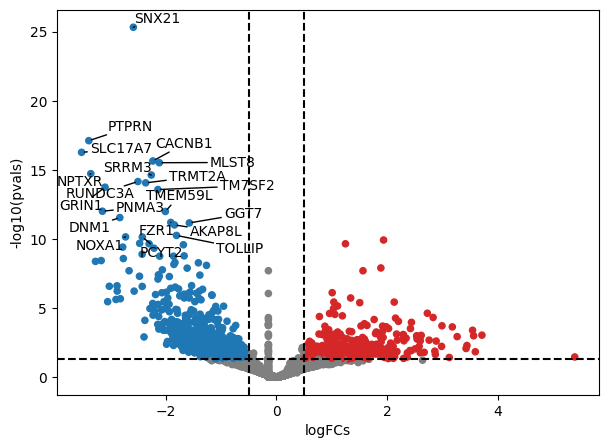

In [22]:
dc.plot_volcano_df(results['Astrocyte'], x='log2FoldChange', y='padj', top=20)


In [8]:
from functions import pathway_analyses

In [7]:
adata_sub = adata_annot[adata_annot.obs.cell_type=='Astrocyte'].copy()
meta = pd.read_csv('../data/raw/leng_etc/leng_etc_metadata.csv')
meta = meta.astype(str )
mapping = dict(zip(meta['PatientID'], meta['pathology.group']))
adata_sub.obs['disease_group'] = adata_sub.obs['PatientID'].map(mapping)


adata_sub.X = adata_sub.layers['counts'].copy()
# sc.pp.normalize_total(adata_sub, target_sum=1e06)
# sc.pp.log1p(adata_sub)

# adata_sub = pathway_analyses.normalize_actionet(adata_sub, layer_key = 'counts', layer_key_out = None,
#                                                 top_features_frac = 1.0, scale_factor = "median",
#                                                 transformation = "log", anchor_features = None, copy = True)

In [8]:
adata_sub

AnnData object with n_obs × n_vars = 5851 × 16585
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'nUMI', 'nGene', 'initialClusterAssignments', 'seurat.clusters', 'clusterAssignment', 'clusterCellType', 'cell_type', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'pathology.group', 'disease_group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'BraakStage_colors', 'PatientID_colors', 'SampleBatch_colors', 'dendrogram_louvain_0.5', 'hvg', 'log.exprs.offset', 'log1p', 'louvain', 'louvain_0.5_colors', 'louvain_1.0_colors', 'neighbors', 'ov_t_test_rank_genes_0.5', 'pca', 'predicted_doublet_colors', 'scrublet', 't_test_rank_genes_0.5', 'tsne', 'umap'
    obsm: 'CCA', 'CCA.ALIGNED', 'X_pca',

In [71]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

In [72]:
adata_sub = prep_anndata(adata_sub)
adata_sub

filtered out 477 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 10449 × 16108
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'nUMI', 'nGene', 'initialClusterAssignments', 'seurat.clusters', 'clusterAssignment', 'clusterCellType', 'cell_type', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'pathology.group', 'disease_group'
    var: 'n_cells'

In [73]:
%%R

library(MAST)

find_de_MAST_RE <- function(adata_, 
                            factor = "disease_group",
                            sc_type = "Excitatory",
                            ref_level = "no", 
                            test_level = "late",
                            replicate_id = "Subject"){

    # """
    # Find differentially expressed genes using MAST package

    # Args:
    #     adata_ (SingleCellExperiment): input single cell data
    #     factor (str): column name for the condition (e.g. treatment or control)
    #     sc_type (str): column name for the cell type
    #     ref_level (str): reference level for the condition
    #     test_level (str): test level for the condition
    #     replicate_id (str): column name for the replicate ID

    # Returns:
    #     A dataframe containing the primerid, log2 fold change and adjusted p-values
    #     for each differentially expressed gene

    # """
    
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")

    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")

    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    colData(sca)$log_total_counts <- log(as.numeric(colData(sca)$total_counts))

    # store the columns that we are interested in as factors
    print('Storing factors as groups...')
    colData(sca)$group <- colData(adata_)[, factor]

    # set the reference level
    print('Setting reference level...')
    colData(sca)$group <- factor(colData(sca)$group)
    colData(sca)$group <- relevel(colData(sca)$group, ref_level)

    # same for donors (which we need to model random effects)
    print('Storing donors as random random effects...')
    colData(sca)$replicate <- factor(colData(sca)[, replicate_id])
    
    print(levels(colData(sca)$group)[1])

    # define and fit the model
    print('Fitting mixed-effects model...')
    zlmCond <- zlm(formula = ~ ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in 
    print('Performing likelihood-ratio test...')
    # summaryCond <- list()
    # result <- list()

    # for (test_name in names(contrasts)){
    #     summaryCond[[test_name]] <- summary(zlmCond, doLRT=contrast[[test_name]])
    #     print(summaryCond[[test_name]], n=4)

    #     # get the table with log-fold changes and p-values
    #     print('Obtaining log-fold-changes and p-values...')
    #     summaryDt[[test_name]] <- summaryCond[[test_name]]$datatable
    #     result[[test_name]] <- merge(summaryDt[contrast==contrast[[test_name]] & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
    #                     summaryDt[contrast==contrast[[test_name]] & component=='logFC', .(primerid, coef)],
    #                     by='primerid') # logFC coefficients
    #     # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    #     print('Converting coefficicients to log2 base...')
    #     result[[test_name]][,coef:=result[[test_name]][,coef]/log(2)]
    #     # do multiple testing correction
    #     print('Multiple testing correction...')
    #     result[[test_name]][,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    #     # result[[test_name]] = result[[test_name]][result[[test_name]]$FDR<0.01,, drop=F]
    #     # result[[test_name]] <- stats::na.omit(as.data.frame(result[[test_name]]))

    # }

    # get the table with log-fold changes and p-values
    print('Obtaining log-fold-changes and p-values...')
    
    lmTest <- lrTest(zlmCond, Hypothesis('0.5*(grouplate + groupearly)'))

    # # get the p-values and log-fold changes from the likelihood ratio test
    hist(lmTest[, "hurdle", "Pr(>Chisq)"], 50)
  
    result <- list(res = lmTest,
         df = data.frame(pval = lmTest[, "hurdle", "Pr(>Chisq)"],
                        padj =  p.adjust(lmTest[, "hurdle", "Pr(>Chisq)"], method = "fdr"),
                        row.names = names(lmTest[, "hurdle", "Pr(>Chisq)"])))

    #logFCs <- lmTest[, "hurdle", "coef"]


    # summaryCond <- summary(zlmCond, doLRT='grouplate')
    # summaryDt <- summaryCond$datatable
    # print(summaryDt)

    # result <- merge(summaryDt[contrast=='grouplate' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
    #                  summaryDt[contrast=='grouplate' & component=='logFC', .(primerid, coef)],
    #                  by='primerid') # logFC coefficients

    # # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    # print('Converting coefficicients to log2 base...')
    # result[,coef:=result[,coef]/log(2)]

    # do multiple testing correction
    # print('Multiple testing correction...')
    # result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    # result = result[result$FDR<0.01,, drop=F]

    # result <- stats::na.omit(as.data.frame(result))
    return(result)
}

[1] "Dimensions before subsetting:"
[1] 16108 10449
[1] ""
[1] "Dimensions after subsetting:"
[1]  5391 10449
[1] ""
[1] "Storing factors as groups..."
[1] "Setting reference level..."
[1] "Storing donors as random random effects..."
[1] "no"
[1] "Fitting mixed-effects model..."
[1] "Performing likelihood-ratio test..."
[1] "Obtaining log-fold-changes and p-values..."


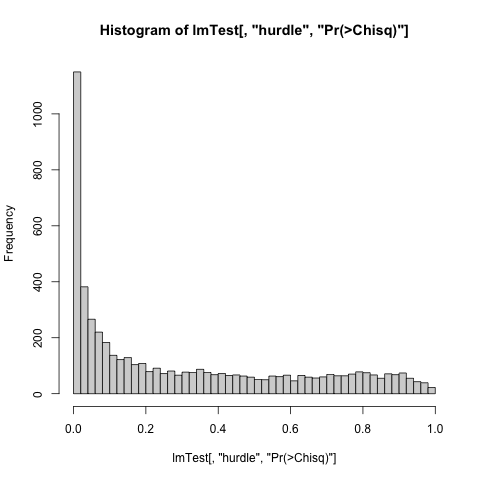

CPU times: user 21min 56s, sys: 1min 3s, total: 23min
Wall time: 23min 13s


In [74]:
%%time
%%R -i adata_sub -o res

res <- find_de_MAST_RE(adata_sub, factor = "disease_group", sc_type = "Excitatory", ref_level = "no", 
                        test_level = "AD", replicate_id = "PatientID")

In [77]:
res['df'].sort_values(by='padj').head(20)

,pval,padj
BAIAP2L1,2.704852e-07,0.000729
PTPRF,1.994673e-07,0.000729
PNPT1,6.183597e-07,0.001111
PCP4,9.592716e-07,0.001293
TF,3.564615e-06,0.003843
MED31,1.362289e-05,0.004672
HMGN3,1.117078e-05,0.004672
B3GAT2,7.674947e-06,0.004672
RPL10A,1.315499e-05,0.004672
SENP7,1.238630e-05,0.004672


In [79]:
adata_sub.obs

,SampleID,PatientID,BrainRegion,BraakStage,SampleBatch,nUMI,nGene,initialClusterAssignments,seurat.clusters,clusterAssignment,...,pct_counts_in_top_50_genes,total_counts_mt,pct_counts_mt,n_genes,doublet_score,predicted_doublet,louvain_0.5,louvain_1.0,pathology.group,disease_group
EC2_AAAGCAACAGATTGCT,EC2,2,EC,0,C,467.0,413,EC:c4,2,EC:Astro,...,22.269807280513916,2.0,0.4282655,413,0.017657861279841786,False,2,4,no,no
EC2_AAAGCAACAGTCTTCC,EC2,2,EC,0,C,325.0,290,EC:c4,2,EC:Astro,...,26.153846153846157,6.0,1.8461539,290,0.07087588981739401,False,2,4,no,no
EC2_AACCGCGAGGGATCTG,EC2,2,EC,0,C,228.0,205,EC:c4,2,EC:Astro,...,32.01754385964912,6.0,2.631579,205,0.009302859768002757,False,2,4,no,no
EC2_AACTCCCCAGCCAATT,EC2,2,EC,0,C,244.0,230,EC:c4,2,EC:Astro,...,26.229508196721312,3.0,1.2295082,230,0.019354838709677417,False,2,4,no,no
EC2_AACTCTTAGCGTAGTG,EC2,2,EC,0,C,228.0,208,EC:c4,2,EC:Astro,...,30.701754385964914,3.0,1.3157895,208,0.05492227979274612,False,2,4,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EC10_TTTGCGCAGCCCAACC,EC10,10,EC,6,D,1094.0,832,EC:c4,2,EC:Astro,...,21.389396709323584,24.0,2.1937842,832,0.015864406779661014,False,2,4,late,late
EC10_TTTGCGCAGTCATCCA,EC10,10,EC,6,D,854.0,615,EC:c4,2,EC:Astro,...,29.859484777517565,4.0,0.46838406,615,0.051896207584830344,False,2,4,late,late
EC10_TTTGGTTTCAACCATG,EC10,10,EC,6,D,5976.0,2921,EC:c4,2,EC:Astro,...,30.3380187416332,23.0,0.38487282,2921,0.0636103151862464,False,2,4,late,late
EC10_TTTGTCAAGCCGGTAA,EC10,10,EC,6,D,447.0,369,EC:c4,2,EC:Astro,...,28.635346756152124,3.0,0.67114097,369,0.02145922746781116,False,2,4,late,late


In [9]:
covariates = ['None']

In [10]:
%%R -i adata_sub -i covariates -o res

library(magrittr)
library(forcats)
library(dplyr)
library(purrr)
library(Matrix)
library(stats)
library(tester)
library(Seurat)
library(methods)
library(matrixStats)
library(edgeR)
library(DESeq2)
library(limma)
library(pbmcapply)
library(parallel)
library(lmerTest)
library(lme4)
library(glmmTMB)
library(blme)


source('../scripts/functions/deg_functions/run_de.R')
source('../scripts/functions/deg_functions/pseudobulk_de.R')
source('../scripts/functions/deg_functions/check_inputs.R')
source('../scripts/functions/deg_functions/to_pseudobulk.R')
source('../scripts/functions/deg_functions/mixedmodel_de.R')
source('../scripts/functions/deg_functions/singlecell_de.R')

test_name = 'ad_vs_no'


assay(adata_sub) <- assay(adata_sub, "counts")
meta = colData(adata_sub)

meta$pathology.group <- factor(meta$pathology.group)
# Set the reference level
print('Setting levels...')
meta$pathology.group <- relevel(meta$pathology.group, ref = 'no')

if (test_name == 'ad_vs_no'){
    adata_sub$pathology.group = ifelse(adata_sub$pathology.group == "no", "no", "ad")
    ref_level <- tail(strsplit('ad_vs_no', "_vs_")[[1]], n = 1)
} else if (test_name %in% c('late_vs_no', 'late_vs_early', 'early_vs_no')){
    adata_sub <- adata_sub[, colData(adata_sub)$pathology.group %in% c(strsplit(test_name, "_vs_")[[1]])]
    ref_level <- tail(strsplit(test_name, "_vs_")[[1]], n = 1)
} 

if ('None' %in% covariates){
    latent_vars = NULL
} else {
    latent_vars = covariates
}

res = run_de(adata_sub,
            meta = meta,
            replicate_col = 'PatientID',
            cell_type_col = 'cell_type',
            label_col = 'pathology.group',
            latent_vars = latent_vars,
            min_cells = 3,
            min_reps = 2,
            min_features = 0,
            de_family = 'pseudobulk',
            de_method = 'edgeR',
            de_type = "QLF",
            n_threads = 2)


[1] "Setting levels..."
[1] "Astrocyte"


In [12]:
res.sort_values(by='p_val_adj')

,cell_type,gene,avg_logFC,p_val,p_val_adj,de_family,de_method,de_type
12732,Astrocyte,SLC17A7,-3.479614,2.862431e-11,4.451855e-07,pseudobulk,edgeR,QLF
9389,Astrocyte,NPTXR,-3.324413,5.771593e-11,4.451855e-07,pseudobulk,edgeR,QLF
11185,Astrocyte,PTPRN,-3.336724,8.052798e-11,4.451855e-07,pseudobulk,edgeR,QLF
5919,Astrocyte,GRIN1,-3.078617,2.503096e-10,1.037846e-06,pseudobulk,edgeR,QLF
9342,Astrocyte,NPAS4,-9.265276,1.385362e-09,3.491032e-06,pseudobulk,edgeR,QLF
...,...,...,...,...,...,...,...,...
4665,Astrocyte,F13B,-0.000000,1.000000e+00,1.000000e+00,pseudobulk,edgeR,QLF
13175,Astrocyte,SMUG1,0.034409,9.604822e-01,1.000000e+00,pseudobulk,edgeR,QLF
15554,Astrocyte,VPS33A,-0.000000,1.000000e+00,1.000000e+00,pseudobulk,edgeR,QLF
4498,Astrocyte,EPN3,-0.000000,1.000000e+00,1.000000e+00,pseudobulk,edgeR,QLF


In [62]:
%%R

# Load required packages
library(lme4)
library(Matrix)
library(multcomp)
library(emmeans)
library(SingleCellExperiment)
library(tidyverse)


# Function to fit GLMER model for a single gene
fit_model <- function(gene_name='LINGO1', data=NULL, counts=NULL, test_name='ad_vs_no') {

    #' Fit GLMER model for a single gene
    #'
    #' This function takes a gene, data, counts, and test_name as inputs and fits GLMER models for that gene.
    #' It then calculates the p-value and log-fold change for the given test.
    #'
    #' @param gene A character vector indicating the name of the gene to be processed.
    #' @param data A data frame with columns 'pathology.group', 'log_total_counts', and 'Subject'.
    #' @param counts A matrix of counts.
    #' @param test_name A character vector indicating the name of the test to be run.
    #' 
    #' @return A list with the p-value and log-fold change for the given test.
    #'
    #' @export

    cat(sprintf("\tProcessing gene %s out of %s...", which(colnames(counts)==gene_name), length(colnames(counts))), "\r")

    # Fit the models
    full_formula <- as.formula(paste(gene_name, "~ 0 + pathology.group + offset(log_total_counts) + (1 | Subject)"))
    null_formula <- as.formula(paste(gene_name, "~ 0 + offset(log_total_counts) + (1 | Subject)"))
    
    df = data[, c(gene_name, 'pathology.group', 'log_total_counts', 'Subject')]
    # Fit generalized linear mixed-effects model
    full_model <- glmer(full_formula, 
          family = "poisson", 
          data = df, 
          nAGQ=10)
          
    null_model <- glmer(null_formula, 
          family = "poisson", 
          data = df, 
          nAGQ=10)

    # Calculate p-value and effect size
    anova_res <- anova(full_model, null_model)
    pval <- anova_res$`Pr(>Chisq)`[2]
    cats <- strsplit(test_name, "_vs_")[[1]]
    # coef_values <- coef(full_model)
    # effect_size <- exp(coef_values$Subject[,paste0("pathology.group", cats[1])][1]) - exp(coef_values$Subject[,paste0("pathology.group", cats[2])][1])
    # z_value = summary(full_model)$Coefficients$`z value`
    # pr_z = summary(full_model)$Coefficients$`Pr(>|z|)`
    # print(summary(full_model))
    return(list('pvals'=pval, 'logfoldchanges'=effect_size, 'z_value'=z_value, 'pr_z'=pr_z))
}

run_mixed_model <- function(sce, 
                            min_cell_frac = 0.1,
                            test_name = 'ad_vs_no',
                            subject_id = 'Subject',
                            library_size_id = 'total_counts',
                            condition_id = 'pathology.group'){

      # """
      # Runs mixed-effects models on a SingleCellExperiment object and returns a data frame with 
      # results for all genes.

      # Parameters
      # ----------
      # sce : SingleCellExperiment object
      #     The SingleCellExperiment object containing gene expression data and metadata.
      # min_cell_frac : float, optional
      #     The minimum detection rate/frequency for a gene to be included in the analysis.
      #     Default is 0.1.
      # test_name : str, optional
      #     The name of the test to run. Default is 'ad_vs_no'.
      # subject_id : str, optional
      #     The name of the column in the metadata containing the subject ID. Default is 'Subject'.
      # library_size_id : str, optional
      #     The name of the column in the metadata containing the library size. Default is 'total_counts'.
      # condition_id : str, optional
      #     The name of the column in the metadata containing the condition. Default is 'pathology.group'.

      # Returns
      # -------
      # result : pandas.DataFrame
      #     A data frame with results for all genes. Contains columns for gene name, p-value, and
      #     log-fold change.

      # """

    # Store the condition column from the metadata as a variable in the SCE object
    sce$pathology.group <- colData(sce)[, condition_id]

    # Check the test_name parameter to determine the reference level for the pathology.group factor
    if (test_name == 'ad_vs_no'){
      sce$pathology.group = ifelse(sce$pathology.group == "no", "no", "ad")
      ref_level <- tail(strsplit('ad_vs_no', "_vs_")[[1]], n = 1)
    } else if (test_name %in% c('late_vs_no', 'late_vs_early', 'early_vs_no')){
      sce <- sce[, colData(sce)$pathology.group %in% c(strsplit(test_name, "_vs_")[[1]])]
      ref_level <- tail(strsplit(test_name, "_vs_")[[1]], n = 1)
    } 

    # Calculate the detection rate/frequency for each gene
    detection_rate <- rowMeans(counts(sce) > 0)

    # Subset the `SingleCellExperiment` object to include only genes with >0.1 detection rate/frequency
    sce <- sce[detection_rate > min_cell_frac, ]

    # Convert SCE to matrix format and transpose
    print('Extracting counts...')
    counts <- assays(sce)$counts
    rownames(counts) <- rownames(sce)
    colnames(counts) <- colnames(sce)
    counts_t <- t(counts)
    rownames(counts_t) <- colnames(sce)

    # Extract metadata from SCE and prepare for modeling
    print('Extracting factors...')
    # Define grouping variable (assuming it's stored as a column in the metadata)
    data <- colData(sce)[, c("pathology.group", library_size_id, subject_id)]
    data$Subject <- data$PatientID
    data$log_total_counts <- log(as.numeric(data$total_counts))
    # Convert the column "pathology.group" to a factor variable
    data$pathology.group <- factor(data$pathology.group)
    # Set the reference level
    print('Setting levels...')
    data$pathology.group <- relevel(data$pathology.group, ref = ref_level)
    print(levels(data$pathology.group))

    # Combine counts and group into a single data frame
    data_t <- cbind.data.frame(counts_t, data)

    print('Fitting models...')
    # Create a list of all genes in data_t and fit GLMER models for each
    genes <- colnames(counts_t)
    
    # Fit GLMER models for all genes in data_t
    gene_models_list <- list()
    for (gene in genes){

          gene_models_list[[gene]] <- tryCatch({
                                # code that might raise an error
                                fit_model(gene_name=gene, data=data_t, counts=counts_t, test_name=test_name)
                                }, error = function(e) {
                                  return(list('pvals'=NaN, 'logfoldchanges'=NaN))
                                })
    }

    # Combine results into a single data frame
    # Create an empty data frame to store the results
    result <- data.frame(gene_name = character(),
                          pvals = numeric(),
                          logfoldchange = numeric(),
                          stringsAsFactors = FALSE)

    # Loop through the gene_models_list and combine the results into a data frame
    for (i in seq_along(gene_models_list)) {
      # Extract the gene name
      gene_name <- names(gene_models_list)[i]
      
      # Extract the pvals and logfoldchanges for the gene
      pvals <- gene_models_list[[i]]$pvals
      logfoldchange <- gene_models_list[[i]]$logfoldchanges
      
      # Combine the results into a data frame
      gene_results <- data.frame(gene_name = gene_name,
                                pvals = pvals,
                                logfoldchange = logfoldchange,
                                stringsAsFactors = FALSE)
      
      # Add the gene_results to the results_df
      result <- do.call(rbind, list(result, gene_results))
    }

  return(result) 
}

In [63]:
%%R -i adata_sub -o result


sce <- adata_sub
result <- run_mixed_model(sce, min_cell_frac=0.1, 
                        test_name = 'late_vs_no', 
                        subject_id = 'PatientID',
                        library_size_id = 'total_counts', 
                        condition_id = 'pathology.group')

[1] "Extracting counts..."
[1] "Extracting factors..."
[1] "Setting levels..."
[1] "no"   "late"
[1] "Fitting models..."
Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 10) [glmerMod]
 Family: poisson  ( log )
Formula: CCNL2 ~ 0 + pathology.group + offset(log_total_counts) + (1 |  
    Subject)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2496.4   2515.7  -1245.2   2490.4     4677 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7932 -0.4061 -0.3132 -0.1637 19.0268 

Random effects:
 Groups  Name        Variance Std.Dev.
 Subject (Intercept) 0.08474  0.2911  
Number of obs: 4680, groups:  Subject, 7

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
pathology.groupno    -8.8107     0.2158  -40.82   <2e-16 ***
pathology.grouplate  -8.7103     0.1731  -50.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          

Exception ignored from cffi callback <function _consolewrite_ex at 0x137105ea0>:
Traceback (most recent call last):
  File "/Users/temitopeleke/miniforge3/envs/pydeseq/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py", line 136, in _consolewrite_ex
    consolewrite_print(s)
  File "/Users/temitopeleke/miniforge3/envs/pydeseq/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py", line 119, in consolewrite_print
    print(s, end='', flush=True)
  File "/Users/temitopeleke/miniforge3/envs/pydeseq/lib/python3.10/site-packages/ipykernel/iostream.py", line 497, in flush
    if not evt.wait(self.flush_timeout):
  File "/Users/temitopeleke/miniforge3/envs/pydeseq/lib/python3.10/threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  File "/Users/temitopeleke/miniforge3/envs/pydeseq/lib/python3.10/threading.py", line 324, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt: 


0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            pthlgy.grpn
pthlgy.grpl 0.002      
Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 10) [glmerMod]
 Family: poisson  ( log )
Formula: PRDM16 ~ 0 + pathology.group + offset(log_total_counts) + (1 |  
    Subject)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  3298.7   3318.1  -1646.4   3292.7     4677 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9659 -0.4857 -0.3842 -0.1954 27.9112 

Random effects:
 Groups  Name        Variance Std.Dev.
 Subject (Intercept) 0.03755  0.1938  
Number of obs: 4680, groups:  Subject, 7

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
pathology.groupno    -7.6211     0.1395  -54.62   <2e-16 ***
pathology.grouplate  -8.4849     0.1180  -71.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    

In [61]:
result.sort_values(by='pvals').head(30)

,gene_name,pvals,logfoldchange
1198,ITPR2,5.444553e-15,-0.000244
1269,N4BP2L2,9.724336e-15,0.000312
694,REV3L,1.346416e-14,-0.000013
1446,RBFOX1,1.434484e-14,-0.000475
387,KALRN,1.512587e-14,-0.000300
415,ARHGEF26,1.817330e-14,0.000017
265,NFE2L2,1.841187e-14,-0.000064
1178,CACNA1C,3.123916e-14,-0.000127
1177,ERC1,3.233465e-14,-0.000006
1598,NOL4,3.781590e-14,-0.000150


In [46]:
%%R

library(edgeR)

fit_model <- function(adata_, ref_level="no", label='pathology.group', replicate='Subject'){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)[, label])
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)[, label])
    group <- factor(group)
    # Set "no-pathology" as the reference level
    group <- relevel(group, ref = ref_level)
    replicate <- factor(colData(adata_)[, replicate])
                            

    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group)
    

    # Define contrast matrix
    contrasts <- makeContrasts("early_vs_no" = groupearly - groupno,
                                "late_vs_early" = grouplate - groupearly,
                               "late_vs_no" = grouplate - groupno,
                                "ad_vs_no" = (groupearly + grouplate)/2 - groupno,
                                levels=design)


    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)

    res <- list()

    # Loop over the contrasts and perform Quasi-Likelihood-Ratio Test for each one
    for (i in 1:ncol(contrasts)){
        # Get the name of the contrast
        contrast_name <- colnames(contrasts)[i]
        qlf <- glmQLFTest(fit, contrast=contrasts[, contrast_name])
        
        tt <- topTags(qlf, n = Inf)
        res[[contrast_name]] <- tt$table
    }

    return(list("fit"=fit, "design"=design, "y"=y, 'result'=res))
}

In [7]:
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [17]:
adata = adata_annot.copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()
meta = meta.astype(str)
mapping = dict(zip(meta['individualID'], meta['pathology.group']))
adata.obs['pathology.group'] = adata.obs['individualID'].map(mapping)
adata.obs['ageDeath'] = adata.obs['individualID'].map(dict(zip(meta['individualID'], meta['ageDeath'])))
adata.obs['pmi'] = adata.obs['individualID'].map(dict(zip(meta['individualID'], meta['pmi'])))
adata.obs['sex'] = adata.obs['individualID'].map(dict(zip(meta['individualID'], meta['sex_y'])))

In [18]:
adata.X = adata.layers["counts"].copy()

In [19]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["individualID"], adata.obs["pathology.group"])
]

In [20]:
adata.obs.columns

Index(['ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes',
       'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId',
       ...
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes',
       'total_counts_mt', 'pct_counts_mt', 'louvain_0.5', 'louvain_1.0',
       'cell_type', 'sex', 'sample'],
      dtype='object', length=107)

In [21]:
adata.obs["individualID"] = adata.obs["individualID"].astype("category")
adata.obs["pathology.group"] = adata.obs["pathology.group"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs['ageDeath'] = adata.obs['ageDeath'].astype('category')
adata.obs['pmi'] = adata.obs['pmi'].astype('category')
adata.obs['sex'] = adata.obs['sex'].astype('category')
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [22]:
import random

In [23]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata,
                                cell_identity = cell_type,
                                donor_key="sample",
                                condition_key="pathology.group",
                                cell_identity_key="cell_type",
                                obs_to_keep=["pathology.group", "cell_type", "individualID", "sample", 'pmi', 'ageDeath', 'sex'],  # which additional metadata to keep, e.g. gender, age, etc
                                replicates_per_patient=1,)

for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata,
                                           cell_identity = cell_type,
                                           donor_key="sample",
                                           condition_key="pathology.group",
                                           cell_identity_key="cell_type",
                                           obs_to_keep=["pathology.group", "cell_type", "individualID", "sample", 'pmi', 'ageDeath', 'sex'],  # which additional metadata to keep, e.g. gender, age, etc
                                           replicates_per_patient=1,)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Astrocyte (1 out of 7)...
	Processing donor 8 out of 8...

Processing Endothelial (2 out of 7)...
	Processing donor 8 out of 8...

Processing Excitatory (3 out of 7)...
	Processing donor 8 out of 8...

Processing Inhibitory (4 out of 7)...
	Processing donor 8 out of 8...

Processing Microglia (5 out of 7)...
	Processing donor 8 out of 8...

Processing OPC (6 out of 7)...
	Processing donor 8 out of 8...

Processing Oligodendrocyte (7 out of 7)...
	Processing donor 8 out of 8...



In [24]:
adata_pb.layers['counts'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [25]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

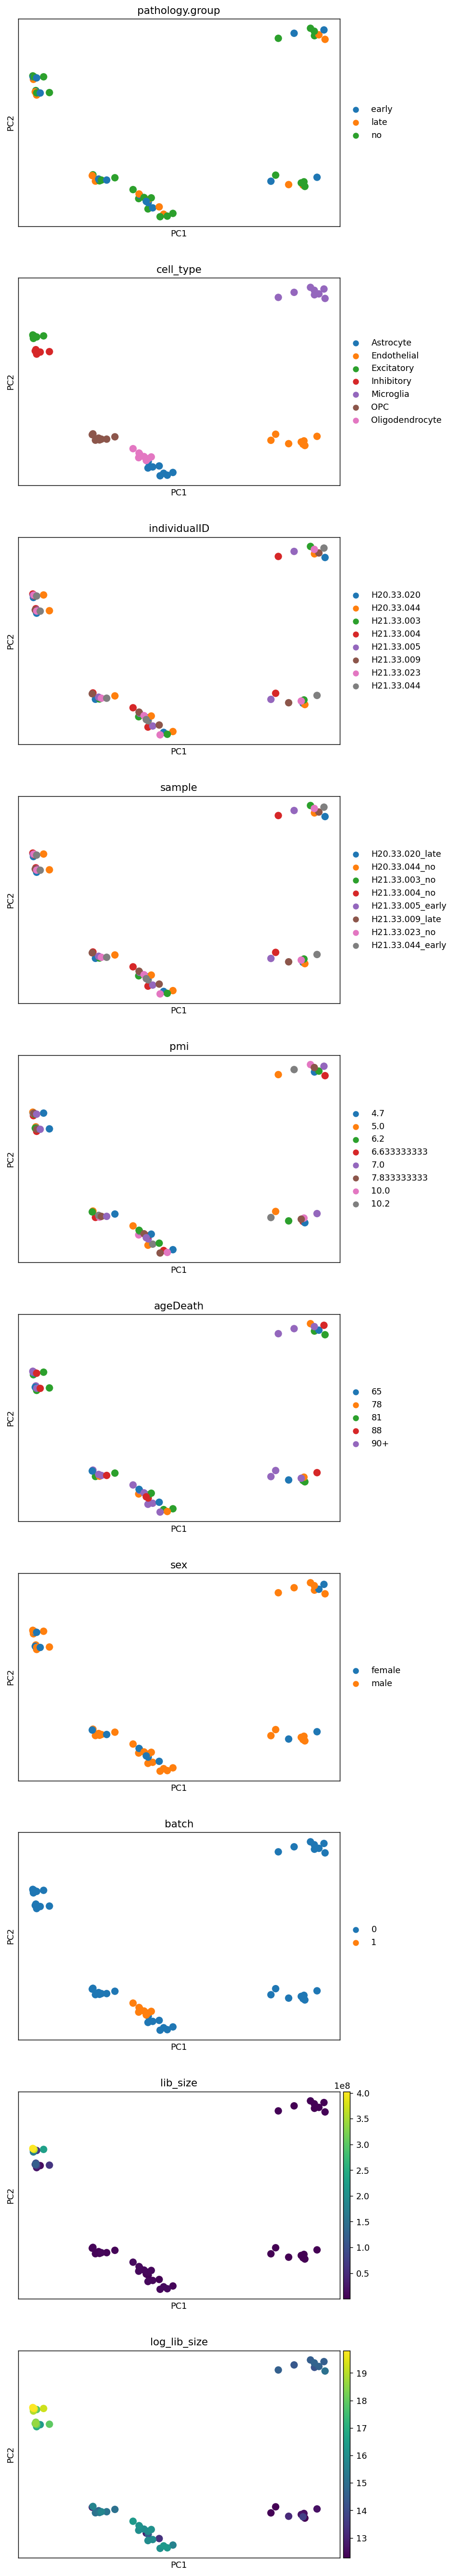

In [26]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [34]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [35]:
adata_ast = adata_pb[adata_pb.obs["cell_type"] == "Excitatory"]
adata_ast

View of AnnData object with n_obs × n_vars = 10 × 16585
    obs: 'pathology.group', 'cell_type', 'PatientID', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'pathology.group_colors', 'cell_type_colors', 'PatientID_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [36]:
adata_ast.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_ast.obs_names
]

In [47]:
%%time
%%R -i adata_ast -o outs

outs <- fit_model(adata_ast, ref='no', label='pathology.group', replicate='PatientID')
fit <- outs$fit
y <- outs$y

[1] "Dimensions before subsetting:"
[1] 16585    10
[1] ""
[1] "Dimensions after subsetting:"
[1] 13351    10
[1] ""
CPU times: user 1.64 s, sys: 218 ms, total: 1.85 s
Wall time: 2.06 s


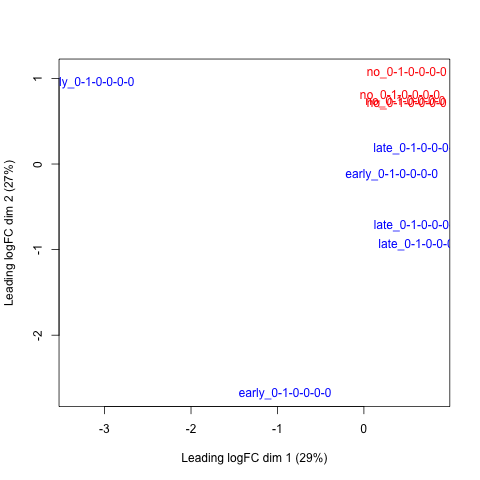

In [38]:
%%R

plotMDS(y, col=ifelse(y$samples$group == "no", "red", "blue"))

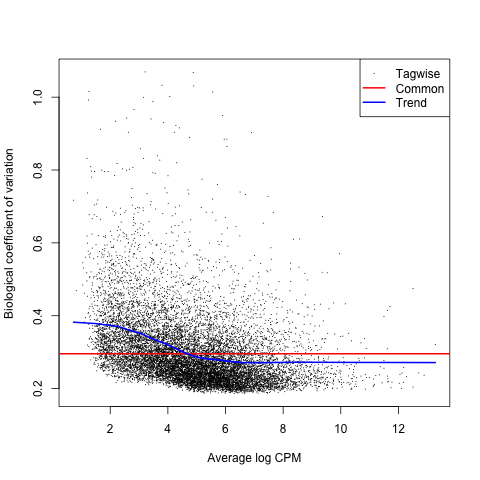

In [39]:
%%R

plotBCV(y)

In [42]:
outs['result']['ad_vs_no'].head(50)

,logFC,logCPM,F,PValue,FDR
ST18,2.478155,5.478800,106.290635,5.968246e-08,0.000797
TF,2.496245,6.214374,85.578011,2.287070e-07,0.001527
SMIM10L2B,-2.370296,5.540303,76.561184,4.495129e-07,0.002000
NPIPB11,-2.594062,6.267783,72.166978,6.406985e-07,0.002138
VSTM2L,-2.247503,5.935290,66.354200,1.054239e-06,0.002391
TRIM54,-2.509327,4.029464,65.378883,1.150212e-06,0.002391
DOC2A,-2.144181,6.690567,63.743752,1.334396e-06,0.002391
CA11,-1.685448,7.681223,61.741448,1.607602e-06,0.002391
HPCA,-1.743661,6.868647,61.377794,1.663807e-06,0.002391
SLC6A17,-1.834676,7.525257,58.720717,2.149909e-06,0.002391
